In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import StringIndexer,OneHotEncoder
from pyspark.sql import SQLContext, SparkSession, Row
from pyspark.mllib.stat import Statistics
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, MinMaxScaler, StandardScaler
from pyspark.sql.functions import col

from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.linalg import Vectors

spark = SparkSession.Builder().appName('DDAM_Project_est').getOrCreate()
df = spark.read.options(inferSchema = True, delimiter = ',', header = True).csv('../../Datasets/East_Incidents_Cleaned.csv')

In [2]:
df.show()

+--------+-------------------+------------------+------------------+-----------+---------+---------+-----+-------------+-------------+-------------+--------------+--------------+----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+-----+---------------+----+------+---------------+---------------------+
|Severity|         Start_Time|         Start_Lat|         Start_Lng|Distance_mi|     City|   County|State|Temperature_F|Humidity_perc|Visibility_mi|Wind_Direction|Wind_Speed_mph|Precipitation_in|Weather_Condition|Amenity| Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station| Stop|Traffic_Calming|Traffic_Signal|month|day_of_the_week|hour|season|Working_Weekend|Astronomical_Twilight|
+--------+-------------------+------------------+------------------+-----------+---------+---------+-----+-------------+-------------+-------------+--------------+--------------+----------------+-------

Preparing data

In [3]:
to_drop=['Start_Time','City','County','State','Wind_Direction','day_of_the_week','season']
df_class=df.drop(*to_drop)
df_class.show()

+--------+------------------+------------------+-----------+-------------+-------------+-------------+--------------+----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+-----+----+---------------+---------------------+
|Severity|         Start_Lat|         Start_Lng|Distance_mi|Temperature_F|Humidity_perc|Visibility_mi|Wind_Speed_mph|Precipitation_in|Weather_Condition|Amenity| Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station| Stop|Traffic_Calming|Traffic_Signal|month|hour|Working_Weekend|Astronomical_Twilight|
+--------+------------------+------------------+-----------+-------------+-------------+-------------+--------------+----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+-----+----+---------------+---------------------+
|       2|         33.032551|        -81.346909|       

In [4]:
colonne_booleane = ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal']

# Converti le colonne booleane in numeriche
for col_name in colonne_booleane:
    df_class = df_class.withColumn(col_name, col(col_name).cast("int"))

df_class.show()


+--------+------------------+------------------+-----------+-------------+-------------+-------------+--------------+----------------+-----------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+-----+----+---------------+---------------------+
|Severity|         Start_Lat|         Start_Lng|Distance_mi|Temperature_F|Humidity_perc|Visibility_mi|Wind_Speed_mph|Precipitation_in|Weather_Condition|Amenity|Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|month|hour|Working_Weekend|Astronomical_Twilight|
+--------+------------------+------------------+-----------+-------------+-------------+-------------+--------------+----------------+-----------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+-----+----+---------------+---------------------+
|       2|         33.032551|        -81.346909|        0.0| 

In [5]:
from pyspark.sql.functions import when, count, isnull



df_class = df_class.withColumn("Astronomical_Twilight", when(df_class["Astronomical_Twilight"] == 'Day', 0).otherwise(1))
df_class = df_class.withColumn("Working_Weekend", when(df_class["Working_Weekend"] == 'WorkingDay', 0).otherwise(1))


df_class.show()

+--------+------------------+------------------+-----------+-------------+-------------+-------------+--------------+----------------+-----------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+-----+----+---------------+---------------------+
|Severity|         Start_Lat|         Start_Lng|Distance_mi|Temperature_F|Humidity_perc|Visibility_mi|Wind_Speed_mph|Precipitation_in|Weather_Condition|Amenity|Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|month|hour|Working_Weekend|Astronomical_Twilight|
+--------+------------------+------------------+-----------+-------------+-------------+-------------+--------------+----------------+-----------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+-----+----+---------------+---------------------+
|       2|         33.032551|        -81.346909|        0.0| 

In [6]:
indexer = StringIndexer(inputCol="Weather_Condition", outputCol="Weather_Condition_Indexed")
df_class = indexer.fit(df_class).transform(df_class)

from pyspark.ml.feature import OneHotEncoder
onehotencoder_vector = OneHotEncoder(inputCol="Weather_Condition_Indexed", outputCol="Weather_Condition_1hot")
df_class = onehotencoder_vector.fit(df_class).transform(df_class)

df_class=df_class.drop('Weather_Condition')
#df_class.show()
df_class=df_class.drop('Weather_Condition_Indexed')
num_col = [item[0] for item in df_class.dtypes if not item[1].startswith('string')]
num_col.remove("Severity")

df_rf= df_class.withColumn("Severity", col("Severity") - 1)
df_rf.show()

+--------+------------------+------------------+-----------+-------------+-------------+-------------+--------------+----------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+-----+----+---------------+---------------------+----------------------+
|Severity|         Start_Lat|         Start_Lng|Distance_mi|Temperature_F|Humidity_perc|Visibility_mi|Wind_Speed_mph|Precipitation_in|Amenity|Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|month|hour|Working_Weekend|Astronomical_Twilight|Weather_Condition_1hot|
+--------+------------------+------------------+-----------+-------------+-------------+-------------+--------------+----------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+-----+----+---------------+---------------------+----------------------+
|       1|         33.032551|        -81.34690

In [7]:
assembler = VectorAssembler(inputCols=num_col, outputCol="features")

output_dataset = assembler.transform(df_rf)

classificationData = output_dataset.select("features", "Severity")

classificationData.show(truncate=False)

+-----------------------------------------------------------------------------------------------------------+--------+
|features                                                                                                   |Severity|
+-----------------------------------------------------------------------------------------------------------+--------+
|(28,[0,1,3,4,5,17,20,21,24],[33.032551,-81.346909,30.0,93.0,10.0,1.0,3.0,6.0,1.0])                         |1       |
|(28,[0,1,2,3,4,5,6,17,20,21,25],[33.023018,-81.274361,0.129,73.0,47.0,10.0,6.0,1.0,3.0,14.0,1.0])          |1       |
|(28,[0,1,2,3,4,5,6,20,21,24],[33.023848,-81.33301800000002,0.122,82.0,15.0,10.0,7.0,3.0,14.0,1.0])         |1       |
|(28,[0,1,3,4,5,20,21],[33.087425,-81.208588,46.0,100.0,0.25,3.0,7.0])                                      |1       |
|(28,[0,1,3,4,5,17,20,21,24],[33.06987,-81.424118,59.0,94.0,10.0,1.0,3.0,6.0,1.0])                          |1       |
|(28,[0,1,3,4,5,10,14,20,21,25],[32.920799,-81.2

In [8]:
(trainingData, testData) = classificationData.randomSplit([0.7, 0.3],seed=0)

In [9]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
 
 
# Train a RandomForest model.
for max_depth in range (5,21,5):
    rf = RandomForestClassifier(labelCol="Severity", featuresCol="features", numTrees=5,maxDepth=max_depth)
    
    
    # Train model.  This also runs the indexers.
    model = rf.fit(trainingData)
    
    
    # Make predictions.
    predictions = model.transform(testData)
    
    evaluator = MulticlassClassificationEvaluator(labelCol="Severity"
                                                , predictionCol="prediction"
                                                , metricName="accuracy")
    
    accuracy = evaluator.evaluate(predictions)
    print(accuracy)
    print("Test Error = %g" % (1.0 - accuracy))
    from pyspark.mllib.evaluation import MulticlassMetrics
    # Calcolare precision, recall e F1-score
    predictionAndLabels = predictions.select("prediction", "Severity").rdd.map(lambda x: (float(x[0]), float(x[1])))
    metrics = MulticlassMetrics(predictionAndLabels)
    print("Max Depth : ",max_depth)
    list_avg=[]
    for i in range(4):
        precision = metrics.precision(label=float(i))  
        recall = metrics.recall(label=float(i))
        f1Score= metrics.fMeasure(label=float(i)) # need .0
        print("Precision for class ",i,": {:.2%}".format(precision))
        print("Recall for class ",i,": {:.2%}".format(recall))
        print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
        list_avg.append(f1Score)
        print('----------------------------')
    sum_=0
    print(list_avg)
    for elem in list_avg:
        sum_+=elem
    
    avg_f1=sum_/4
    print('----------------------')
    
    print("avg_F1-Score: {:.2%}".format(avg_f1))
    
    

0.8936409917579392
Test Error = 0.106359


/Applications/anaconda3/lib/python3.8/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Max Depth :  5
Precision for class  0 : 74.83%
Recall for class  0 : 2.87%
avg_F1-Score for class  0 : 5.53%
----------------------------
Precision for class  1 : 89.38%
Recall for class  1 : 99.98%
avg_F1-Score for class  1 : 94.38%
----------------------------
Precision for class  2 : 0.00%
Recall for class  2 : 0.00%
avg_F1-Score for class  2 : 0.00%
----------------------------
Precision for class  3 : 0.00%
Recall for class  3 : 0.00%
avg_F1-Score for class  3 : 0.00%
----------------------------
[0.055325749741468463, 0.9438262621739617, 0.0, 0.0]
----------------------
avg_F1-Score: 24.98%
0.9169525552082539
Test Error = 0.0830474
Max Depth :  10
Precision for class  0 : 69.11%
Recall for class  0 : 78.15%
avg_F1-Score for class  0 : 73.35%
----------------------------
Precision for class  1 : 92.89%
Recall for class  1 : 98.61%
avg_F1-Score for class  1 : 95.66%
----------------------------
Precision for class  2 : 71.95%
Recall for class  2 : 33.09%
avg_F1-Score for class  2 :

Confusion Matrix Max_depth = 20

In [10]:
rf = RandomForestClassifier(labelCol="Severity", featuresCol="features", numTrees=5,maxDepth=20)
model = rf.fit(trainingData)
predictions = model.transform(testData)
# Calcolare precision, recall e F1-score
predictionAndLabels = predictions.select("prediction", "Severity").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictionAndLabels)





<AxesSubplot:>

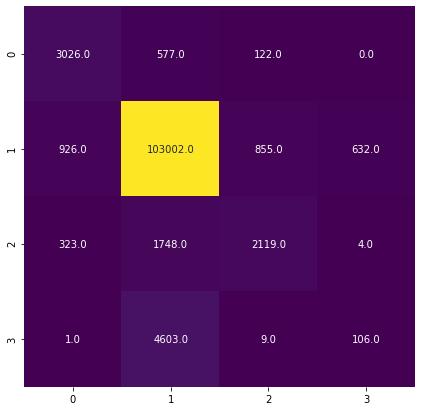

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
 
labels = ["0", "1", "2", "3"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)

In [12]:
model.featureImportances

SparseVector(28, {0: 0.1027, 1: 0.0813, 2: 0.3543, 3: 0.0665, 4: 0.0535, 5: 0.0154, 6: 0.0428, 7: 0.0105, 8: 0.0021, 9: 0.0001, 10: 0.007, 11: 0.0024, 12: 0.0082, 13: 0.0006, 14: 0.0014, 16: 0.0018, 17: 0.0049, 18: 0.0004, 19: 0.0148, 20: 0.0974, 21: 0.0809, 22: 0.0218, 23: 0.0061, 24: 0.0088, 25: 0.0085, 26: 0.0044, 27: 0.0016})

In [13]:
predictions.select('prediction').distinct().collect()

[Row(prediction=0.0),
 Row(prediction=1.0),
 Row(prediction=3.0),
 Row(prediction=2.0)]

In [14]:
prediction_counts = predictions.groupBy("prediction").count()

# Stampare i risultati
print("Counts of predictions in the test set:")
prediction_counts.show()

Counts of predictions in the test set:
+----------+------+
|prediction| count|
+----------+------+
|       0.0|  4276|
|       1.0|109930|
|       3.0|   742|
|       2.0|  3105|
+----------+------+



In [15]:
prediction_counts = predictions.groupBy("Severity").count()

# Stampare i risultati
prediction_counts.show()

+--------+------+
|Severity| count|
+--------+------+
|       1|105415|
|       3|  4719|
|       2|  4194|
|       0|  3725|
+--------+------+



In [16]:
severity_counts_train= trainingData.groupBy("Severity").count()

# Mostra il risultato
severity_counts_train.show()

+--------+------+
|Severity| count|
+--------+------+
|       1|246643|
|       3| 10918|
|       2|  9968|
|       0|  8937|
+--------+------+



In [17]:
severity_counts_test= testData.groupBy("Severity").count()

# Mostra il risultato
severity_counts_test.show()

+--------+------+
|Severity| count|
+--------+------+
|       1|105415|
|       3|  4719|
|       2|  4194|
|       0|  3725|
+--------+------+



In [18]:
from pyspark.sql.types import FloatType
from pyspark.mllib.evaluation import MulticlassMetrics

from pyspark.sql import functions as F

#important: need to cast to float type, and order by prediction, else it won't work
preds_and_labels = predictions.select(['prediction','Severity']).withColumn('label', F.col('Severity').cast(FloatType())).orderBy('prediction')

#select only prediction and label columns
preds_and_labels = preds_and_labels.select(['prediction','label'])

metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

print(metrics.confusionMatrix())



DenseMatrix([[3.02600e+03, 5.77000e+02, 1.22000e+02, 0.00000e+00],
             [9.26000e+02, 1.03002e+05, 8.55000e+02, 6.32000e+02],
             [3.23000e+02, 1.74800e+03, 2.11900e+03, 4.00000e+00],
             [1.00000e+00, 4.60300e+03, 9.00000e+00, 1.06000e+02]])


Undersampling

In [19]:
from pyspark.sql import functions as F

 
g=trainingData.groupBy('Severity').agg(F.count('Severity').alias('Count'))

g=g.sort('Severity')

g_p=g.toPandas()

n_0=g_p.iloc[0,1]

n_1=g_p.iloc[1,1]

n_2=g_p.iloc[2,1]

n_3=g_p.iloc[3,1]

und=(n_0+n_2+n_3)/3

train_und = trainingData.sampleBy('Severity', fractions={0:1.0 ,1: und/n_1 , 2:1.0, 3:1.0})

result_counts=train_und.groupBy("Severity").count()

result_counts.show()

+--------+-----+
|Severity|count|
+--------+-----+
|       1| 9971|
|       3|10918|
|       2| 9968|
|       0| 8937|
+--------+-----+



Training & Testing random forest with training Data sampled

In [20]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
 
 
# Train a RandomForest model.
for max_depth in range (5,21,5):
    rf = RandomForestClassifier(labelCol="Severity", featuresCol="features", numTrees=5,maxDepth=max_depth)
    
    
    # Train model.  This also runs the indexers.
    model = rf.fit(train_und)
    
    
    # Make predictions.
    predictions = model.transform(testData)
    
    evaluator = MulticlassClassificationEvaluator(labelCol="Severity"
                                                , predictionCol="prediction"
                                                , metricName="accuracy")
    
    accuracy = evaluator.evaluate(predictions)
    print(accuracy)
    print("Test Error = %g" % (1.0 - accuracy))
    from pyspark.mllib.evaluation import MulticlassMetrics
    # Calcolare precision, recall e F1-score
    predictionAndLabels = predictions.select("prediction", "Severity").rdd.map(lambda x: (float(x[0]), float(x[1])))
    metrics = MulticlassMetrics(predictionAndLabels)
    print("Max Depth : ",max_depth)
    list_avg=[]
    for i in range(4):
        precision = metrics.precision(label=float(i))  
        recall = metrics.recall(label=float(i))
        f1Score= metrics.fMeasure(label=float(i)) # need .0
        print("Precision for class ",i,": {:.2%}".format(precision))
        print("Recall for class ",i,": {:.2%}".format(recall))
        print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
        list_avg.append(f1Score)
        print('----------------------------')
    sum_=0
    print(list_avg)
    for elem in list_avg:
        sum_+=elem
    
    avg_f1=sum_/4
    print('----------------------')
    
    print("avg_F1-Score: {:.2%}".format(avg_f1))
    
    

0.42187830889515726
Test Error = 0.578122
Max Depth :  5
Precision for class  0 : 41.63%
Recall for class  0 : 77.53%
avg_F1-Score for class  0 : 54.17%
----------------------------
Precision for class  1 : 97.94%
Recall for class  1 : 37.88%
avg_F1-Score for class  1 : 54.63%
----------------------------
Precision for class  2 : 25.17%
Recall for class  2 : 71.72%
avg_F1-Score for class  2 : 37.26%
----------------------------
Precision for class  3 : 6.81%
Recall for class  3 : 84.30%
avg_F1-Score for class  3 : 12.61%
----------------------------
[0.5417370099418496, 0.5463015535322164, 0.37264618434093166, 0.12605161842292884]
----------------------
avg_F1-Score: 39.67%
0.5568261712959434
Test Error = 0.443174
Max Depth :  10
Precision for class  0 : 54.97%
Recall for class  0 : 89.72%
avg_F1-Score for class  0 : 68.17%
----------------------------
Precision for class  1 : 97.90%
Recall for class  1 : 52.53%
avg_F1-Score for class  1 : 68.37%
----------------------------
Precision 

Confusion Matrix MaxDepth=20

In [21]:
rf = RandomForestClassifier(labelCol="Severity", featuresCol="features", numTrees=5,maxDepth=20)
model = rf.fit(train_und)
predictions = model.transform(testData)
# Calcolare precision, recall e F1-score
predictionAndLabels = predictions.select("prediction", "Severity").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictionAndLabels)





<AxesSubplot:>

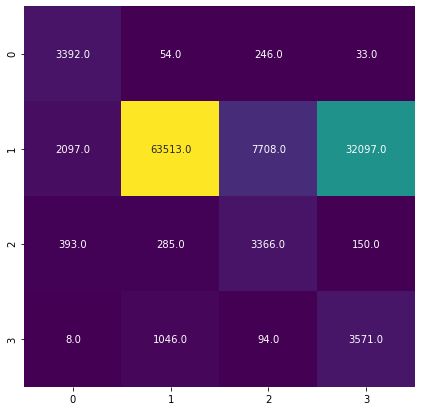

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
 
labels = ["0", "1", "2", "3"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)

In [23]:
model.featureImportances

SparseVector(28, {0: 0.1276, 1: 0.0962, 2: 0.3191, 3: 0.0581, 4: 0.0477, 5: 0.0112, 6: 0.0377, 7: 0.0083, 8: 0.0013, 10: 0.0075, 11: 0.0007, 12: 0.0073, 13: 0.0005, 14: 0.0005, 16: 0.0017, 17: 0.004, 18: 0.0001, 19: 0.0315, 20: 0.1078, 21: 0.0767, 22: 0.0217, 23: 0.0127, 24: 0.007, 25: 0.0075, 26: 0.0036, 27: 0.0019})

Performing Undersampling(Severity=1) & Oversampling(Severity=0,2,3)

In [24]:
under_1=trainingData.filter(col('Severity') == 1)
under_1 = trainingData.sample(True, 0.3, seed=42)

In [25]:
oversample_0=trainingData.filter(col('Severity') == 0)
num_campioni_da_generare = round(n_1*0.3)
num_campioni_da_generare=(num_campioni_da_generare-n_0)/n_0 
full_0=oversample_0

while num_campioni_da_generare>1:
    oversample_0 = oversample_0.unionAll(full_0)
    num_campioni_da_generare=num_campioni_da_generare-1.0
    print(num_campioni_da_generare)
    
df_minority_oversampled = full_0.sample(True, num_campioni_da_generare, seed=42)

oversample_0 = oversample_0.unionAll(df_minority_oversampled)

6.279400246167618
5.279400246167618
4.279400246167618
3.2794002461676177
2.2794002461676177
1.2794002461676177
0.2794002461676177


In [26]:
oversample_2=trainingData.filter(col('Severity') == 2)
num_campioni_da_generare = round(n_1*0.3)
num_campioni_da_generare=(num_campioni_da_generare-n_2)/n_2
full_2=oversample_2

while num_campioni_da_generare>1:
    oversample_2 = oversample_2.unionAll(full_2)
    num_campioni_da_generare=num_campioni_da_generare-1.0
    print(num_campioni_da_generare)
    
df_minority_oversampled = full_2.sample(True, num_campioni_da_generare, seed=42)

oversample_2 = oversample_2.unionAll(df_minority_oversampled)

5.423053772070626
4.423053772070626
3.4230537720706264
2.4230537720706264
1.4230537720706264
0.42305377207062644


In [27]:
oversample_3=trainingData.filter(col('Severity') == 3)
num_campioni_da_generare = round(n_1*0.3)
num_campioni_da_generare=(num_campioni_da_generare-n_3)/n_3  
full_3=oversample_3

while num_campioni_da_generare>1:
    oversample_3 = oversample_3.unionAll(full_3)
    num_campioni_da_generare=num_campioni_da_generare-1.0
    print(num_campioni_da_generare)
    
df_minority_oversampled = full_3.sample(True, num_campioni_da_generare, seed=42)

oversample_3 = oversample_3.unionAll(df_minority_oversampled)

4.777156988459425
3.777156988459425
2.777156988459425
1.7771569884594252
0.7771569884594252


In [28]:
class0_counts=oversample_0.count()
class2_counts=oversample_2.count()
class3_counts=oversample_3.count()
class1_counts=under_1.count()
print(f'Class 0: {class0_counts}\nClass 1: {class1_counts}\nClass 2: {class2_counts}\nClass 3: {class3_counts}')

Class 0: 73974
Class 1: 82835
Class 2: 73977
Class 3: 73914


In [29]:
train_und_over=oversample_0.unionAll(oversample_2).unionAll(oversample_3).unionAll(under_1)

In [30]:
g=train_und_over.groupBy('Severity').agg(F.count('Severity').alias('Count'))
g=g.sort('Severity')
g.show()

+--------+-----+
|Severity|Count|
+--------+-----+
|       0|76682|
|       1|73872|
|       2|77029|
|       3|77117|
+--------+-----+



In [31]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
 
# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="Severity", featuresCol="features", numTrees=5,maxDepth=15)
 
 
# Train model.  This also runs the indexers.
model = rf.fit(train_und_over)
 
 
# Make predictions.
predictions = model.transform(testData)
 
evaluator = MulticlassClassificationEvaluator(labelCol="Severity"
                                              , predictionCol="prediction"
                                              , metricName="accuracy")
 
accuracy = evaluator.evaluate(predictions)
print(accuracy)
print("Test Error = %g" % (1.0 - accuracy))
from pyspark.mllib.evaluation import MulticlassMetrics
# Calcolare precision, recall e F1-score
predictionAndLabels = predictions.select("prediction", "Severity").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictionAndLabels)
 
list_avg=[]
for i in range(4):
    precision = metrics.precision(label=float(i))  
    recall = metrics.recall(label=float(i))
    f1Score= metrics.fMeasure(label=float(i)) # need .0
    print("Precision for class ",i,": {:.2%}".format(precision))
    print("Recall for class ",i,": {:.2%}".format(recall))
    print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
    list_avg.append(f1Score)
    print('----------------------------')
sum_=0
print(list_avg)
for elem in list_avg:
    sum_+=elem
 
avg_f1=sum_/4
print('----------------------')
 
print("avg_F1-Score: {:.2%}".format(avg_f1))

0.697889930793796
Test Error = 0.30211
Precision for class  0 : 59.35%
Recall for class  0 : 91.84%
avg_F1-Score for class  0 : 72.10%
----------------------------
Precision for class  1 : 97.79%
Recall for class  1 : 68.52%
avg_F1-Score for class  1 : 80.58%
----------------------------
Precision for class  2 : 36.92%
Recall for class  2 : 77.28%
avg_F1-Score for class  2 : 49.97%
----------------------------
Precision for class  3 : 11.78%
Recall for class  3 : 74.04%
avg_F1-Score for class  3 : 20.33%
----------------------------
[0.7210454210138055, 0.8058144658824056, 0.4996531257226548, 0.20333459423283964]
----------------------
avg_F1-Score: 55.75%


<AxesSubplot:>

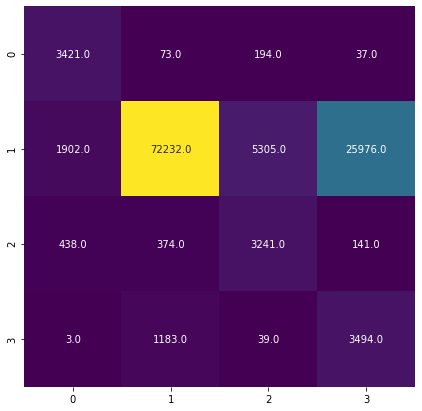

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
 
labels = ["0", "1", "2", "3"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)

In [33]:
model.featureImportances

SparseVector(28, {0: 0.1269, 1: 0.092, 2: 0.3647, 3: 0.053, 4: 0.0279, 5: 0.0067, 6: 0.0216, 7: 0.0051, 8: 0.0007, 9: 0.0, 10: 0.0076, 11: 0.0006, 12: 0.0058, 13: 0.0001, 14: 0.0005, 16: 0.0012, 17: 0.0037, 18: 0.0, 19: 0.0472, 20: 0.1193, 21: 0.0716, 22: 0.0198, 23: 0.0129, 24: 0.0035, 25: 0.0038, 26: 0.0022, 27: 0.0015})

### Classificazione binaria 

In [34]:
num_col = [item[0] for item in df_class.dtypes if not item[1].startswith('string')]
num_col.remove("Working_Weekend")
assembler = VectorAssembler(inputCols=num_col, outputCol="features")

output_dataset = assembler.transform(df_rf)

classificationData = output_dataset.select("features", "Working_Weekend")

classificationData.show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------+---------------+
|features                                                                                                         |Working_Weekend|
+-----------------------------------------------------------------------------------------------------------------+---------------+
|(28,[0,1,2,4,5,6,18,21,22,24],[1.0,33.032551,-81.346909,30.0,93.0,10.0,1.0,3.0,6.0,1.0])                         |0              |
|(28,[0,1,2,3,4,5,6,7,18,21,22,25],[1.0,33.023018,-81.274361,0.129,73.0,47.0,10.0,6.0,1.0,3.0,14.0,1.0])          |0              |
|(28,[0,1,2,3,4,5,6,7,21,22,24],[1.0,33.023848,-81.33301800000002,0.122,82.0,15.0,10.0,7.0,3.0,14.0,1.0])         |0              |
|(28,[0,1,2,4,5,6,21,22],[1.0,33.087425,-81.208588,46.0,100.0,0.25,3.0,7.0])                                      |0              |
|(28,[0,1,2,4,5,6,18,21,22,24],[1.0,33.06987,-81.424118,59.0,94.0,10.0,1.0,3

In [35]:
(trainingData, testData) = classificationData.randomSplit([0.7, 0.3],seed=0)

In [36]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
 
# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="Working_Weekend", featuresCol="features", numTrees=5,maxDepth=15)
 
 
# Train model.  This also runs the indexers.
model = rf.fit(trainingData)
 
 
# Make predictions.
predictions = model.transform(testData)
 
evaluator = MulticlassClassificationEvaluator(labelCol="Working_Weekend"
                                              , predictionCol="prediction"
                                              , metricName="accuracy")
 
accuracy = evaluator.evaluate(predictions)
print(accuracy)
print("Test Error = %g" % (1.0 - accuracy))
from pyspark.mllib.evaluation import MulticlassMetrics
# Calcolare precision, recall e F1-score
predictionAndLabels = predictions.select("prediction", "Working_Weekend").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictionAndLabels)
 
list_avg=[]
for i in range(2):
    precision = metrics.precision(label=float(i))  
    recall = metrics.recall(label=float(i))
    f1Score= metrics.fMeasure(label=float(i)) # need .0
    print("Precision for class ",i,": {:.2%}".format(precision))
    print("Recall for class ",i,": {:.2%}".format(recall))
    print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
    list_avg.append(f1Score)
    print('----------------------------')
sum_=0
print(list_avg)
for elem in list_avg:
    sum_+=elem
 
avg_f1=sum_/2
print('----------------------')
 
print("avg_F1-Score: {:.2%}".format(avg_f1))

0.8122622889719024
Test Error = 0.187738
Precision for class  0 : 81.24%
Recall for class  0 : 99.11%
avg_F1-Score for class  0 : 89.29%
----------------------------
Precision for class  1 : 80.84%
Recall for class  1 : 14.10%
avg_F1-Score for class  1 : 24.01%
----------------------------
[0.8929008065178627, 0.24013439846401757]
----------------------
avg_F1-Score: 56.65%


Confusion matrix

<AxesSubplot:>

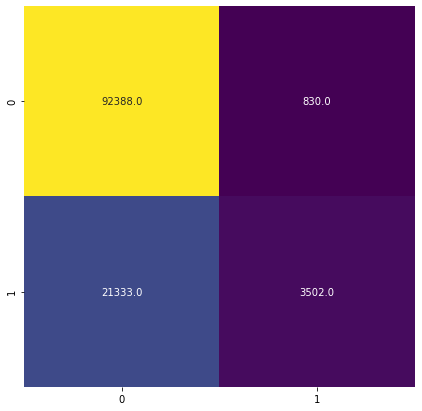

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
 
labels = ["0", "1"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)

In [38]:
model.featureImportances

SparseVector(28, {0: 0.0425, 1: 0.0855, 2: 0.0686, 3: 0.0842, 4: 0.1245, 5: 0.0798, 6: 0.0379, 7: 0.0744, 8: 0.0188, 9: 0.0024, 10: 0.0001, 11: 0.0038, 12: 0.0013, 13: 0.0047, 14: 0.0006, 15: 0.0017, 17: 0.0016, 18: 0.003, 19: 0.0003, 20: 0.0052, 21: 0.1063, 22: 0.1859, 23: 0.0266, 24: 0.0099, 25: 0.009, 26: 0.0048, 27: 0.0166})